In [1]:
#use base environment
import pandas as pd
import icecream as ic
import numpy as np
import plotly
import matplotlib as plt
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
# from chemicalchecker import ChemicalChecker
# cc = ChemicalChecker()

from standardiser import unsalt, neutralise,rules
from standardiser.rules_demo import show_change

import e3fp
from e3fp.pipeline import confs_from_smiles
import csv


import six

import warnings

import sys
import re
import random

# from ipywidgets import HTML

import pandas as pd

from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (450, 200)
PandasTools.RenderImagesInAllDataFrames()

from e3fp.config.params import read_params
from e3fp.pipeline import fprints_from_mol
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol,MakeScaffoldGeneric

from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.Chem import inchi
from qed import qed


In [2]:
#import setting from Standardizer
from __future__  import print_function, division, absolute_import

import six

import warnings

import sys
import re
import random
 
# from ipywidgets import HTML

import pandas as pd
 
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (450, 200)
PandasTools.RenderImagesInAllDataFrames()

from urllib.request import urlopen
from urllib.parse import quote



In [3]:

chemical_list = ['Acetazolamide','Acetylcholine','Adenosine']


In [4]:

def CIRconvert(ids): #convert name to smile
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'


In [14]:
CIRconvert('Acetazolamide')

'CC(=O)Nc1sc(nn1)[S](N)(=O)=O'

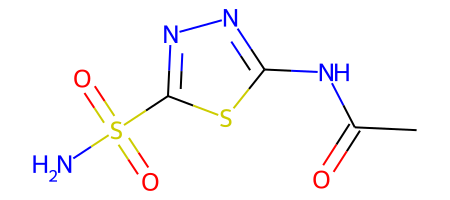

In [5]:
Acetazolamide = "CC(=O)NC1=NN=C(S1)S(=O)(=O)N"
mol = Chem.MolFromSmiles(Acetazolamide)

# Default
mol


https://chemicalchecker.org/explore/BZKPWHYZMXOIDC-UHFFFAOYSA-N

Standardization

In [6]:
def standardize(mol):
    #Using standardizer (https://github. com/flatkinson/standardiser)
    #unsalt
    # The unsalt module identifies counterions and solvate components, such that they can be removed. It does not do the removal itself, as each component is put through the whole standardization pipeline before counterions and/or solvate components are identified. Note that any component containing an non-organic element is removed before the standardization pipeline is applied.
    non_salt_frags = []

    for frag in Chem.GetMolFrags(mol, asMols=True):
        if unsalt.is_nonorganic(frag): continue # Looks for any 'non-organic' element
        if unsalt.is_salt(frag): continue       # Uses salt dictionary
        non_salt_frags.append(frag)
        
    Draw.MolsToGridImage(non_salt_frags)

    #neuralise
    # This document describes the operation of the neutralize module, which attempts to balance charges via the removal and/or addition of protons.
    mol = neutralise.run(non_salt_frags[0])

    #Tautemers
    # Tautomers are isomers of a molecule that exist in solution or in a cell. They are interchangeable forms because chemical bonds are rearranged many times spontaneously. 
    # rules.logger.setLevel('DEBUG')
    # rules.add_rule_set('tautomerism_and_aromaticity')
    # HTML(show_change(mol))
    # print(mol)

    #outputing Inchikey after standardization
    inchikey = inchi.MolToInchiKey(mol)
    return mol


A1: 2D fingerprints

In [7]:
#morgan finger print with radius of 2
# The Morgan fingerprint is basically a reimplementation of the extended conectivity fingerprint (ECFP). 
# 5)Extended-connectivity fingerprints (ECFPs) are a recently developed fingerprint methodology explicitly designed to capture molecular features relevant to molecular activity.
def a1_func(mol):
    info = {}
    morgan_fp = AllChem.GetMorganFingerprint(mol,2,bitInfo=info)
    # print(morgan_fp)
    len(morgan_fp.GetNonzeroElements())
    return list(info.keys())
# Information is available about the atoms that contribute to particular bits in the Morgan fingerprint via the bitInfo argument. The dictionary provided is populated with one entry per bit set in the fingerprint, the keys are the bit ids, the values are lists of (atom index, radius) tuples.

A2: 3D fingerprints

In [8]:
#3D fingerprints. The 1,024-bit E3FP fingerprints 
# 3D molecular fingerprinting method inspired by Extended Connectivity FingerPrints (ECFP) 2, integrating tightly with the RDKit
def a2_func(x):
    # config = read_params("e3fp/new_params.cfg")

    confgen_params = {'max_energy_diff': 20.0, 'first': 3}
    fprint_params = {'bits': 1024, 'radius_multiplier': 2, 'rdkit_invariants': True}

    conformer = confs_from_smiles(CIRconvert(x), x, confgen_params=confgen_params);
    # conformer.GetNumConformers()

    fprints = fprints_from_mol(conformer, fprint_params=fprint_params);
    return fprints

A3: scaffolds

In [9]:
#Murcko’s scaffold
# This method employs a more systematical way to dissect a molecule into four parts: ring systems, linkers, side chains, and the Murcko framework that is the union of ring systems and linkers in a molecule.
def a3_func(mol):
    Mscaffold = Chem.MolToSmiles(GetScaffoldForMol(mol))
    # Chem.MolToSmiles(Mscaffold)
    #molecular framework
    # mol_Mscaffold = Chem.MolFromSmiles(Mscaffold)
    # fw = MakeScaffoldGeneric(mol)
    # print(fw)
    return Mscaffold

A4: structural keys

In [10]:
def a4_func(mol):
    # MACCS keys are used to compute molecular similarity for computational drug design and database matching. This function follows the RDKit implementation of the 166-bit MACCS keys.
    fps = MACCSkeys.GenMACCSKeys(mol)
    return fps.ToBitString()

A5: physicochemical parameters

In [11]:
from rdkit.Chem import Descriptors, rdMolDescriptors, rdchem, Crippen,Lipinski
from rdkit.Chem.rdchem import StereoType
#molecular weight, 

def chemicalAlert(query):
    alert_df = pd.read_csv("DB/alert_collection.csv")
    for x in alert_df['smarts']:
        if x in query:
            return 1
        else:
            return 0 
        
def a5_func(mol):
    physicochemical = []
    mw = Descriptors.ExactMolWt(mol)
    physicochemical.append(mw)

    # number of heavy atoms
    nHeavy = rdMolDescriptors.CalcNumHeavyAtoms(mol)
    physicochemical.append(nHeavy)


    # number of heteroatoms
    nHetero = rdMolDescriptors.CalcNumHeteroatoms(mol) 
    physicochemical.append(nHetero)

    # number of rings
    nRing = rdMolDescriptors.CalcNumRings(mol) 
    physicochemical.append(nRing)

    # number of aliphatic rings 
    nAliphatic = rdMolDescriptors.CalcNumAliphaticRings(mol)
    physicochemical.append(nAliphatic)
    
    # number of aromatic rings
    nAromatic = rdMolDescriptors.CalcNumAromaticRings(mol)
    physicochemical.append(nAromatic)

    # number of hydrogen bond acceptors
    nHBA = rdMolDescriptors.CalcNumHBA(mol)
    physicochemical.append(nHBA)
    
    #! GetNumBonds
    #nAliphatic = rdchem.GetBonds(mol)
    # double = StereoType.Bond_Double(mol)
    rotatable = Lipinski.NumRotatableBonds(mol)
    nBond =rotatable #+ double 
    physicochemical.append(nBond) 

    # number of hydrogen bond donors 
    nHBD = rdMolDescriptors.CalcNumHBD(mol)
    physicochemical.append(nHBD)
    
    # number of rotatable bonds
    nRotatable = rdMolDescriptors.CalcNumRotatableBonds(mol)
    physicochemical.append(nRotatable)

    # logP
    logP = Crippen.MolLogP(mol)
    physicochemical.append(logP)

    #! molecular refractivity

    # polar surface area

    psurface = rdMolDescriptors.CalcTPSA(mol)
    physicochemical.append(psurface)

    #Structural alert
    # Parts of organic molecules which are believed to be responsible for adverse effects (e.g. genotoxicity) and can be used to predict the toxicity of similar compounds.


    alert = chemicalAlert(Acetazolamide)
    physicochemical.append(alert)

    #Lipinski’s rule-of-five violations
    # Molecular weight <= 500
    # LogP <= 5
    # H-bond donor count <= 5
    # H-bond acceptor count <= 10
    rule_of_five = [mw <= 500,logP <= 5,nHBD <=5,nHBA <=5]
    r5 = all(item is True for item in rule_of_five)
    physicochemical.append(r5)

    #rule-of-three violations
    # molecular weight of a fragment is <300
    # the v is ≤3
    # the number of hydrogen bond donors is ≤3
    # the number of hydrogen bond acceptors is ≤3.
    rule_of_three = [mw <= 300,logP <= 3,nHBD <=3,nHBA <=3]
    r3 = all(item is True for item in rule_of_three)

    #chemical beauty (QED)
    QED = qed.weights_max(mol)
    physicochemical.append(QED)

    return physicochemical

# Running

In [12]:
A1_result = []
A2_result = []
A3_result = []
A4_result = []
A5_result = []

for x in chemical_list:    
    mol = Chem.MolFromSmiles(CIRconvert(x))
    mol = standardize(mol)
    morgan = a1_func(mol)
    A1_result.append(morgan)
    fprints = a2_func(x)
    A2_result.extend(fprints)
    Mscaffold = a3_func(mol)
    A3_result.append(Mscaffold)
    keys = a4_func(mol)
    A4_result.append(keys)
    physicochemical = a5_func(mol)
    A5_result.append(physicochemical)


2022-11-27 21:31:20,641|INFO|Generating conformers for Acetazolamide.
2022-11-27 21:31:20,935|INFO|Generated 3 conformers for Acetazolamide.
2022-11-27 21:31:20,935|INFO|Generating fingerprints for Acetazolamide.
2022-11-27 21:31:21,044|INFO|Generated 3 fingerprints for Acetazolamide.
2022-11-27 21:31:22,326|INFO|Generating conformers for Acetylcholine.
2022-11-27 21:31:22,734|INFO|Generated 3 conformers for Acetylcholine.
2022-11-27 21:31:22,735|INFO|Generating fingerprints for Acetylcholine.
2022-11-27 21:31:22,818|INFO|Generated 3 fingerprints for Acetylcholine.
2022-11-27 21:31:24,033|INFO|Generating conformers for Adenosine.
2022-11-27 21:31:25,079|INFO|Generated 3 conformers for Adenosine.
2022-11-27 21:31:25,079|INFO|Generating fingerprints for Adenosine.
2022-11-27 21:31:25,253|INFO|Generated 3 fingerprints for Adenosine.
